In [55]:
!pip install opencv-python matplotlib numpy

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [56]:
!pip install tifffile

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [57]:
import sys

In [80]:
import os
import tifffile
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [81]:
sys.path.append("/home/b858680f-9d82-4866-9261-e695c0b00008/CytoImageNet/cytoimagenet")

In [82]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [83]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [84]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tqdm.notebook import tqdm

In [85]:
pretrained_model = EfficientNetB0(weights = 'imagenet', include_top=False, pooling='avg')
#loading pretrained model from cytoimagenet
print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [86]:
#need to preprocess the images before they go into the model

#need to define the image as single or multichannel
def detect_file_type(filename):
    filename = filename.lower()

    if 'c1+2+3+4' in filename:
        return 'multi'
    elif any(f'c{i}' in filename for i in range(1,5)):
        return 'single'
    else:
        return 'unknown'

def load_single_channel(filepath):
    img = Image.open(filepath)
    img = img.convert("RGB")  # Convert grayscale/single channel to RGB automatically
    img = img.resize((224, 224))
    img = np.array(img)
    img = img / 255.0
    return img
        
'''
#function if the image is a single channel
def load_single_channel(filepath):
    img = tifffile.imread(filepath)

    if len(img.shape) == 2:  #looking for 2 dimension to clarify greyscale
        img = np.expand_dims(img, axis=-1) #adding channel axis

    #duplicate into 3 channels
    img = np.repeat(img, 3, axis=-1)
    
    # Resize to EfficientNet size
    img = cv2.resize(img, (224, 224))
    
    # Normalize for EfficientNet
    img = preprocess_input(img.astype(np.float32))
    
    return img
'''
def load_multi_channel(filepath):
    img = tifffile.imread(filepath)  # Load full multi-channel image

    # Just for debugging:
    print(f"Multi-channel image shape: {img.shape}")

    # If image has shape (224, 224, 9), keep first 3 channels
    if img.ndim == 3 and img.shape[-1] >= 3:
        img = img[..., :3]
    else:
        # If something unexpected happens
        img = np.stack([img]*3, axis=-1)

    # Resize (if needed, but looks like you're already 224x224)
    img = cv2.resize(img, (224, 224))

    # Normalize for EfficientNet
    img = img / 255.0

    return img

'''
#function if the image is multiple channels
def load_multi_channel(filepath):
    img = tifffile.imread(filepath)
    
    # Handle channels-first format if necessary
    if img.shape[0] <= 4 and len(img.shape) == 3:
        img = np.moveaxis(img, 0, -1)
    
    # Take only first 3 channels for EfficientNet
    if img.shape[-1] > 3:
        img = img[:, :, :3]
    
    # If fewer than 3 channels somehow, pad by repeating channels
    elif img.shape[-1] < 3:
        img = np.repeat(img, 3, axis=-1)
    
    # Resize & Normalize
    img = cv2.resize(img, (224, 224))
    img = preprocess_input(img.astype(np.float32))
    
    return img

'''

#the image is now being read and preprocessed
def load_and_preprocess(filepath):
    filename = os.path.basename(filepath)
    file_type = detect_file_type(filename) #calling the file type function from above

    if file_type == 'multi':
        return load_multi_channel(filepath)
    elif file_type == 'single':
        return load_single_channel(filepath)
    else:
       raise ValueError(f"Cannot determine image type for file: {filename}")
    

In [87]:
data_folder = 'Kemka Sample Data'

In [88]:
all_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(('.tif', '.tiff'))]


In [89]:
features = [] #stores the features from each image
filenames = [] #stores the name of each image file

for file in tqdm(all_files):
    try: 
        img = load_and_preprocess(file) #calls the preprocessing function
        img_batch = np.expand_dims(img, axis=0) #adds a dimension
        feature_vector = pretrained_model.predict(img_batch) #the pretrained features will then come in and match pretrained to visible features
        features.append(feature_vector.flatten()) #flatten the feature and put it into the array
        filenames.append(os.path.basename(file))
    except Exception as e:
        print(f"Error processing {file}: {e}")

  0%|          | 0/120 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Multi-channel image shape: (1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Multi-channel image shape: (1945, 1946, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Multi-channel image shape: (1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Multi-channel image shape: (1945, 1946, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Multi-channel image shape: (1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [90]:
features_df = pd.DataFrame(features, index=filenames)
features_df.to_csv("extracted_features.csv")

print("✅ Features extracted and saved!")

✅ Features extracted and saved!


In [91]:
df = pd.read_csv("extracted_features.csv", index_col=0)
df.head()

0         1  \
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.070332 -0.099626   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.070457 -0.099513   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.070157 -0.099370   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.070125 -0.099347   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.069938 -0.099527   

                                                           2         3  \
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.133513 -0.076017   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.133178 -0.075949   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.133118 -0.076064   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.133100 -0.075924   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.132537 -0.075353   

                                                           4         5  \
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.158827 -0.131083   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.158987 -0.131199   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.158999 -0.130676   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.158876 -0.130556   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.158840 -0.131844   

                                                           6         7  \
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.065405 -0.191166   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.065336 -0.191333   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.065290 -0.191441   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.065271 -0.191419   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.064984 -0.190971   

                                                           8         9  ...  \
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.183887 -0.174603  ...   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.184091 -0.174585  ...   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.184037 -0.174455  ...   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.183884 -0.174457  ...   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.183893 -0.174155  ...   

                                                        1270      1271  \
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.048450 -0.175172   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.048362 -0.175357   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.048265 -0.175262   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.048277 -0.175256   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.048388 -0.175051   

                                                        1272      1273  \
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.202790 -0.137236   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.202823 -0.137328   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.202684 -0.137272   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.202612 -0.137147   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.202997 -0.137016   

                                                        1274      1275  \
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.242014 -0.224890   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.241945 -0.224871   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.241931 -0.224848   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.241930 -0.224869   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.242254 -0.224836   

                                                        1276      1277  \
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.035923 -0.194606   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.035901 -0.194243   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.035895 -0.194457   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.035899 -0.194436   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon... -0.035933 -0.194257   

                        

In [93]:
print(df.shape)
#number of images, number of features

(120, 1280)


In [94]:
df.describe()

0           1           2           3           4           5  \
count  120.000000  120.000000  120.000000  120.000000  120.000000  120.000000   
mean    -0.070149   -0.099403   -0.133107   -0.075874   -0.158930   -0.130857   
std      0.000139    0.000100    0.000189    0.000228    0.000094    0.000340   
min     -0.070457   -0.099792   -0.133798   -0.076126   -0.159082   -0.131948   
25%     -0.070200   -0.099430   -0.133174   -0.076063   -0.158998   -0.131043   
50%     -0.070148   -0.099379   -0.133103   -0.075956   -0.158971   -0.130770   
75%     -0.070118   -0.099357   -0.133066   -0.075723   -0.158894   -0.130635   
max     -0.069537   -0.099053   -0.132516   -0.075053   -0.158604   -0.129714   

                6           7           8           9  ...        1270  \
count  120.000000  120.000000  120.000000  120.000000  ...  120.000000   
mean    -0.065237   -0.191324   -0.183962   -0.174421  ...   -0.048323   
std      0.000103    0.000147    0.000133    0.000099  ...    0.000068   
min     -0.065405   -0.191468   -0.184094   -0.174606  ...   -0.048616   
25%     -0.065298   -0.191447   -0.184033   -0.174473  ...   -0.048361   
50%     -0.065288   -0.191385   -0.184012   -0.174442  ...   -0.048293   
75%     -0.065189   -0.191231   -0.183958   -0.174386  ...   -0.048274   
max     -0.064819   -0.190893   -0.183417   -0.174140  ...   -0.048253   

             1271        1272        1273        1274        1275        1276  \
count  120.000000  120.000000  120.000000  120.000000  120.000000  120.000000   
mean    -0.175181   -0.202799   -0.137229   -0.242018   -0.224874   -0.035902   
std      0.000181    0.000143    0.000079    0.000111    0.000087    0.000017   
min     -0.175357   -0.203230   -0.137328   -0.242333   -0.225436   -0.035965   
25%     -0.175265   -0.202891   -0.137277   -0.242076   -0.224894   -0.035904   
50%     -0.175232   -0.202720   -0.137261   -0.241951   -0.224861   -0.035897   
75%     -0.175147   -0.202687   -0.137205   -0.241933   -0.224832   -0.035893   
max     -0.173897   -0.202612   -0.136956   -0.241882   -0.224653   -0.035850   

             1277        1278        1279  
count  120.000000  120.000000  120.000000  
mean    -0.194373   -0.050012    0.052843  
std      0.000144    0.000152    0.000422  
min     -0.194612   -0.050213    0.050998  
25%     -0.194483   -0.050124    0.052823  
50%     -0.194425   -0.050073    0.052898  
75%     -0.194267   -0.049950    0.053046  
max     -0.193801   -0.049452    0.053712  

[8 rows x 1280 columns]

In [95]:
print(df.isna().sum().sum())

0


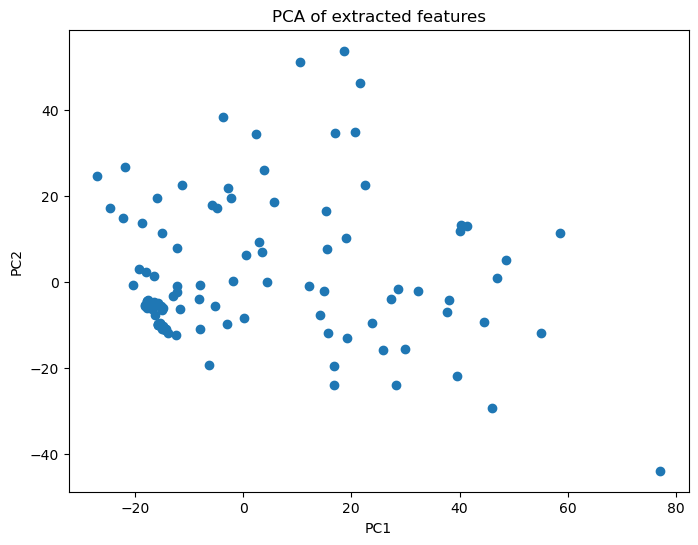

In [97]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

# Run PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Plot PCA
plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,0], pca_result[:,1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of extracted features")
plt.show()